In [1]:
#load datasets
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_PascalSchenider_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ok
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok
firepolygon = gpd.read_parquet('../data/processed_datasets/simplified_firepolygons_2017_2020_FR_EPSG2154.parquet') #ok

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:
firepolygon['class'] = 'Fire'
#add end date with offset of 7 days 
firepolygon['end_date'] = pd.to_datetime(firepolygon['start_date']) + pd.to_timedelta(7, unit='d')
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms, 'firepolygons':firepolygon}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'firepolygons': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'firepolygons': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 50}),
        'temporal': ('offset_gaussian', {'offset': 7, 'decrease': 31})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .75, 'bdiff': 1.0, 'cdi':.75, 'forms':0.75, 'firepolygons':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100, 'firepolygons':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


In [2]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [22]:
import geopandas as gpd 
clusters = gpd.read_parquet('sample_download_clusters.parquet')
sub = clusters[ clusters.cluster ==  528].rename(columns={'class': 'cause'})

from utils import compute_class_similarity_v2, compute_spatial_distance_v2, compute_tree_coherence_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
kwds = {
    'DBSCAN': {'eps': 0.23, 'min_samples': 2},
    'HDBSCAN': {'min_cluster_size': 2}
}
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

from constants import DCLASS_SCORE
from utils import get_matrices_v2, build_similarity_v2, get_cluster_v2  
weight = weights['equal']
method = 'DBSCAN'
kwargs = kwds[method]
data = sub
matrice = get_matrices_v2(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict)
similarity = build_similarity_v2(matrice, weight)
gdf, _, labels = get_cluster_v2(data, similarity, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) 

#show
all_indexes = []
list_gdf = []
for name, row in gdf.iterrows():
    g = all_clusters_gdf[all_clusters_gdf.index.isin(row.Indexes)]
    g['Cluster_Class'] = row['Class']
    list_gdf.append(g)

gdf_polygons = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=gdf.crs)
#change Start_Date and End_Date to str
gdf_polygons['start_date'] = gdf_polygons['start_date'].dt.strftime('%Y-%m-%d')
gdf_polygons['end_date'] = gdf_polygons['end_date'].dt.strftime('%Y-%m-%d')
gdf_polygons.drop(['centroid_date'],axis=1, inplace=True)
gdf_polygons.explore(column='Cluster_Class')

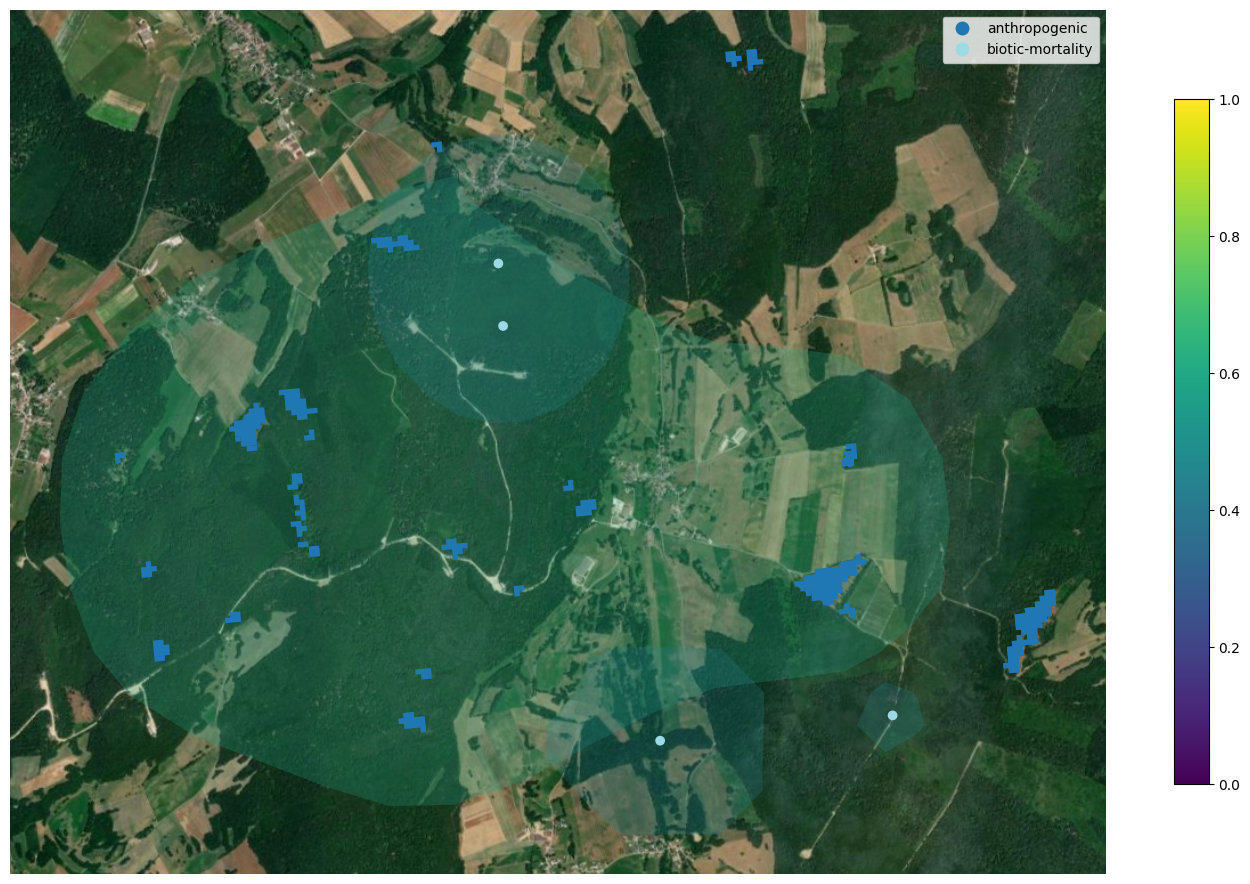

In [24]:
#Spatial and Temporal closed forms estimation of disturbance clusters from reliability profiles
import matplotlib.pyplot as plt
import contextily as ctx
plt.ion()
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

gdf.plot(ax=ax, column='IntraSimilarity', legend=True, cmap='viridis', alpha=0.25, legend_kwds={'shrink': 0.5}, vmin=0, vmax=1)
gdf_polygons.plot(column='Cluster_Class', ax=ax, legend=True, cmap='tab20', alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, attribution=False, crs=gdf.crs.to_string())
ax.set_axis_off()
fig.tight_layout()
fig.savefig(f'../figures/clusters_{method}_eps023_528.png', dpi=300)
